# Task B2 - Eye Colour Detector

by Mohamed Azmil Irfan Mohamed Amiruddin

(AMLS 19/20 ASSIGNMENT)

## Import Library

In [1]:
import os
import cv2
import dlib
import requests
import numpy as np
import pandas as pd
from math import hypot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Directory List
relevant folder
1. Image directory : ..\AMLS_19-20_SN15053755\dataset\cartoon_set\img
2. Label CSV file directory : ..\AMLS_19-20_SN15053755\dataset\cartoon_set\labels.csv

In [2]:
os.chdir("..")
print(os.path.abspath(os.curdir))

labels_filename = 'labels.csv'

basedir = os.path.abspath(os.curdir)
dataset_dir = os.path.join(basedir,'dataset')
cartoon_dir = os.path.join(dataset_dir,'cartoon_set')
images_dir = os.path.join(cartoon_dir,'img')
labels_dir = os.path.join(cartoon_dir,labels_filename)

C:\Users\Bear-\Desktop\AMLS_19-20_SN15053755


## Using HaarCascade Eyes + Glasses

In [3]:
# Downloading haarcascade feature set from github
def __downloadCascadeFF():
    print("Downloading haarcascade for face detection")
    url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml"
    folder = "./B2/"
    local_filename = folder + url.split('/')[-1]
    # Check if already exists on users disk
    if not os.path.exists(folder):
        os.makedirs(folder)
    # Stream download dataset to local disk
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

def __downloadCascadeEye():
    print("Downloading haarcascade for eye detection")
    url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml"
    folder = "./B2/"
    local_filename = folder + url.split('/')[-1]
    # Check if already exists on users disk
    if not os.path.exists(folder):
        os.makedirs(folder)
    # Stream download dataset to local disk
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

__downloadCascadeEye()
__downloadCascadeFF()
print("Download Complete !")

Download Complete !


In [4]:
face_cascade = cv2.CascadeClassifier('C:\\Users\\Bear-\\Desktop\\AMLS_19-20_SN15053755\\B2\\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:\\Users\\Bear-\\Desktop\\AMLS_19-20_SN15053755\\B2\\haarcascade_eye_tree_eyeglasses.xml')

### Get Coordinates from eye_cascade classifier
Use any random image that can be detected using eye_cascade classifier

175 230 58 58


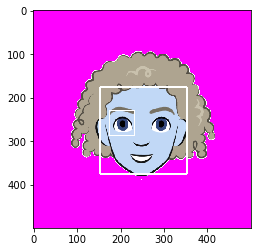

In [5]:
def detection(images_dir, image):
    img_path = os.path.join(images_dir, image)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    trans_mask = img[:,:,3] == 0
    img[trans_mask] = [255,0,255,255] ## Purple BGRA
    purple_img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img_gray = cv2.cvtColor(purple_img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(img_gray, 1.7, 3)
    for (x,y,w,h) in faces:
        purple_img = cv2.rectangle(img,(x,y),(x+w,y+h), (255,0,0), 2)
        roi_gray = img_gray[y:y+h, x:x+w]
        roi_color = purple_img[y:y+h, x:x+w]
        
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.7, 3)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh), (0,255,0), 2)
            print(ex+x,ey+y,ew,eh)
            
    return purple_img

example_image = '4.png'
extract_image = detection(images_dir, example_image)

image_plot = plt.imshow(extract_image)

### Try a new function to extract eye

In [6]:
def cropeye(images_dir, image):
    img_path = os.path.join(images_dir, image)
    img =  cv2.imread(img_path)
    cropped = img[230:230+58, 175:175+58]
    
    return cropped

Image :6904.png
Successful cropped eye


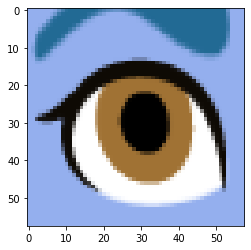

In [7]:
import random
image_name = str(random.randrange(1,9999)) + '.png'
image_name = str(image_name)
print("Image :" + image_name)
temp = cropeye(images_dir, image_name)
image_plot = plt.imshow(temp)
print("Successful cropped eye")

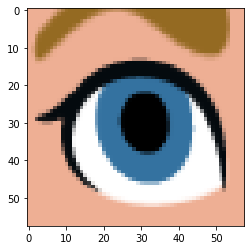

In [8]:
## Print real image
plt.imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))

### Using Hough Circles to find the eye

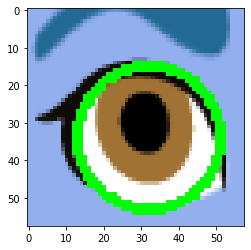

In [9]:
tempcopy = temp.copy()
tempgray = cv2.cvtColor(tempcopy,cv2.COLOR_BGR2GRAY)
tempgray = cv2.medianBlur(tempgray,5)

circles = cv2.HoughCircles(tempgray,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=6,maxRadius=20)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(tempcopy,(i[0],i[1]),i[2],(0,255,0),2)

plt.imshow(tempcopy)

### Cut circled image and replace background with white

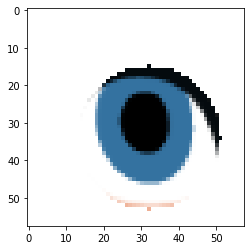

In [10]:
from math import hypot

masky = temp.copy()
real = cv2.cvtColor(temp.copy(), cv2.COLOR_BGR2RGB)
x, y, r = circles[0,:][0]
rows, cols = tempgray.shape

for i in range(cols):
    for j in range(rows):
        if hypot(i-x, j-y) > r:
            masky[j,i] = 255 ## White background behind

real = cv2.cvtColor(masky, cv2.COLOR_BGR2RGB)
plt.imshow(real)

### Display the histogram
Print the maximum values for all three channels while include white (since background dominates and there is no white eye)

160

114

52

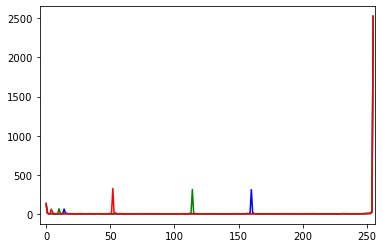

In [11]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([masky],[i],None,[256],[0,256])
    ayy = np.delete(histr, 255)
    display(np.argmax(ayy))
    plt.plot(histr,color = col)
    plt.xlim([-5,256])
plt.show()

### Create a function to extract all images and labels

In [12]:
def cropeye(images_dir, image): ## Change crop function to output bigger
    img_path = os.path.join(images_dir, image)
    img =  cv2.imread(img_path)
    cropped = img[230:230+60, 175:175+60]
    
    return cropped


def extract_feature_colour(images_dir, labels_dir):
    """ return:
        colour_features: an array contain argmax colour for BGR
        eye_labels: an array containing eye colour 1-5
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(labels_dir, 'r')
    lines = labels_file.readlines()
    eye_label = {line.split('\t')[0] : int(line.split('\t')[1]) for line in lines[1:]}
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        error_features = []
        for img_path in image_paths:
            file_name = img_path.split('.')[0].split('\\')[-1]
            crop = cropeye(images_dir, img_path.split('\\')[-1])
            gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            gray = cv2.medianBlur(gray,5)
            circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1,
                                       20,param1=50, param2=30,
                                       minRadius=6, maxRadius=40)
            
            # Could not find eye circle
            if circles is None:
                error_features.append(file_name)
                
            # Eye circle found
            else:
                circles = np.uint16(np.around(circles))
                x,y,r = circles[0,:][0]
                mask = crop.copy() ## Copy crop
                
                rows, cols = gray.shape
                for i in range(cols):
                    for j in range(rows):
                        if hypot(i-x, j-y) > r:
                            mask[j,i] = 255 ## white background

                bgr = []
                colour = ('b', 'g', 'r')
                for i, col in enumerate(colour):
                    histr = cv2.calcHist([mask],[i], None, [256], [0,256])
                    temp = np.delete(histr, 255)
                    bgr.append(np.argmax(temp))

#                 # check rgb within range and apply penalty if its not
#                 b,g,r = bgr
#                 if(checkbound(b,g,r) == False):
#                     bgr.append(0)
#                 else:
#                     bgr.append(1)
                
                all_features.append(bgr)
                all_labels.append(eye_label[file_name])
                
    colour_features = np.array(all_features)
    eye_labels = np.array(all_labels)
    
    return colour_features, eye_labels, error_features

### Extract Data and Label

In [13]:
feat, lab, err = extract_feature_colour(images_dir, labels_dir)

In [14]:
print(len(feat))
print(len(lab))
print(len(err))
print(err)

7695
7695
2305
['1003', '1004', '1007', '1012', '1015', '102', '1020', '1022', '1023', '1033', '1041', '1042', '1045', '1048', '1049', '1055', '1063', '1066', '1084', '1094', '11', '1104', '1108', '1109', '1110', '1115', '1132', '1134', '1138', '1141', '1142', '1143', '1144', '1146', '115', '1154', '1156', '1158', '1159', '116', '1160', '1162', '1163', '1165', '1166', '1167', '1178', '1187', '1188', '1191', '1194', '1198', '1199', '1204', '1205', '1208', '1211', '1217', '1219', '1223', '1224', '1225', '1232', '1237', '124', '1241', '1243', '1244', '1246', '1262', '1266', '127', '1276', '1278', '1279', '1281', '1283', '1285', '1291', '1293', '1294', '1295', '13', '1300', '1301', '1303', '1305', '1306', '1307', '1311', '1315', '1318', '1321', '1322', '1326', '1331', '1337', '1339', '1348', '1349', '135', '1351', '1356', '136', '1361', '137', '1376', '1381', '1386', '1392', '1396', '1399', '1400', '1403', '1414', '1417', '1420', '1423', '1428', '1431', '1436', '144', '1446', '1451', '1458

Error is quite high. Hough Circle sometimes cannot be detected for some reason.

### Data Visualisation

In [15]:
dataset = pd.DataFrame(list(lab))
dataset.columns = ['EyeLabel']

EyeColour = []
for eye in dataset.EyeLabel:
    if eye == 0:
        EyeColour.append("Brown")
    elif eye == 1:
        EyeColour.append("Blue")
    elif eye == 2:
        EyeColour.append("Green")
    elif eye == 3:
        EyeColour.append("Gray")
    else:
        EyeColour.append("Black")
dataset['EyeColour'] = EyeColour

B = []
G = []
R = []

for l in range(len(feat)):
    b,g,r = feat[l]
    B.append(b)
    G.append(g)
    R.append(r)
dataset['R'] = R
dataset['G'] = G
dataset['B'] = B

print(dataset)

      EyeLabel EyeColour    R    G    B
0            1      Blue   28    7    6
1            2     Green   14    9    9
2            2     Green   96   61   48
3            1      Blue   28   13   12
4            3      Gray  227  180  126
...        ...       ...  ...  ...  ...
7690         2     Green  114  147   67
7691         3      Gray  148  164  160
7692         0     Brown  124   72   53
7693         1      Blue  246  216  193
7694         2     Green   14    9    9

[7695 rows x 5 columns]


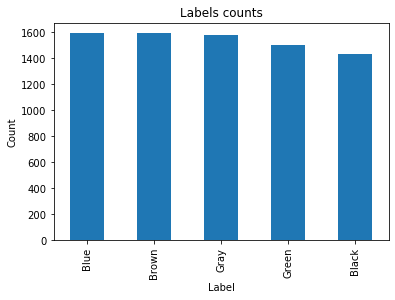

In [16]:
dataset.EyeColour.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

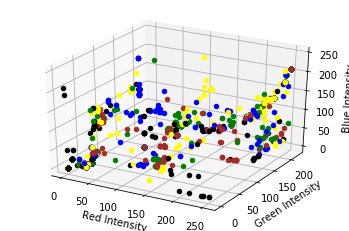

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection ='3d')

for i in range(len(dataset['EyeLabel'])):
    xR = dataset.R[i]
    yG = dataset.G[i]
    zB = dataset.B[i]
    col = dataset.EyeLabel[i]
    if col == 0:
        k = 'brown'
    elif col == 1:
        k = 'blue'
    elif col == 2:
        k = 'green'
    elif col == 3: ##gray
        k = 'yellow'
    else:
        k = 'black'
    
    ax.scatter(xR, yG, zB, c = k)
    
ax.set_xlabel('Red Intensity')
ax.set_ylabel('Green Intensity')
ax.set_zlabel('Blue Intensity')

plt.show()

### Standardize Features by removing mean and scale to unit variance

In [18]:
from sklearn.preprocessing import StandardScaler

stsc = StandardScaler().fit(feat)
feat_stsc = stsc.transform(feat)

print(feat_stsc)

[[-1.19354128 -1.31482045 -0.97792044]
 [-1.14734631 -1.28600527 -1.15013326]
 [-0.54681163 -0.53681054 -0.14145814]
 ...
 [-0.46982001 -0.37832705  0.20296751]
 [ 1.6859455   1.69636603  1.70367928]
 [-1.14734631 -1.28600527 -1.15013326]]


### Split data into train and test data set

In [19]:
train_data, test_data, train_label, test_label = train_test_split(feat_stsc, lab, test_size=0.2, random_state=99)

### Model Training & Evaluation

In [20]:
from sklearn.ensemble import RandomForestClassifier #1
from sklearn.neighbors import KNeighborsClassifier #2
from sklearn.svm import SVC #3
from sklearn.tree import DecisionTreeClassifier #4
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

#### 1. Using Random Forest Classifier

In [21]:
clf1 = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 5, max_features='auto',n_jobs=4)
clf1.fit(train_data,train_label)
pred1 = clf1.predict(test_data)
acc1 = accuracy_score(test_label, pred1)
print(acc1)

0.6478232618583496


#### 2. Using K-Neighbors Classifier

In [22]:
clf2 = KNeighborsClassifier(n_neighbors=5, algorithm='auto', n_jobs=4)
clf2.fit(train_data, train_label)
pred2 = clf2.predict(test_data)
acc2 = accuracy_score(test_label, pred2)
print(acc2)

0.6556205328135153


#### 3. Using SVC w/ Linear Classifier

In [23]:
clf3 = SVC(kernel = 'rbf', C=0.1, gamma='auto')
clf3.fit(train_data, train_label)
pred3 = clf3.predict(test_data)
acc3 = accuracy_score(test_label, pred3)
print(acc3)

0.6335282651072125


Accuracy for this method produce very low accuracy (below 70). Hence author continue modelling cropped image with labels using CNN.

## Using CNN method 

### Set DataFrame

In [24]:
labels_file = open(labels_dir, 'r')
lines = labels_file.readlines()
eye_label = {line.split('\t')[3].split('\n')[0] : int(line.split('\t')[1])+1 for line in lines[1:]}

dfCNN = pd.DataFrame(list(eye_label.items()))
dfCNN.columns = ['FileName', 'EyeLabel']

EyeColour = []
for eye in dfCNN.EyeLabel:
    if eye == 1:
        EyeColour.append("Brown")
    elif eye == 2:
        EyeColour.append("Blue")
    elif eye == 3:
        EyeColour.append("Green")
    elif eye == 4:
        EyeColour.append("Gray")
    else:
        EyeColour.append("Black")
dfCNN['EyeColour'] = EyeColour

display(dfCNN.head(10))

,FileName,EyeLabel,EyeColour
0,0.png,2,Blue
1,1.png,3,Green
2,2.png,3,Green
3,3.png,3,Green
4,4.png,1,Brown
5,5.png,5,Black
6,6.png,4,Gray
7,7.png,4,Gray
8,8.png,2,Blue
9,9.png,3,Green


### Split DataFrame into Training and Testing

In [25]:
train_df, test_df = train_test_split(dfCNN, test_size=0.2 ,random_state=11)
print(len(train_df))
print(len(test_df))

8000
2000


### Crop Image and Save to new directory

In [26]:
done = True

def cropimage(images_dir, new_dir):
    count = 0
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    if os.path.isdir(images_dir):
        for img_path in image_paths:
            file_name = img_path.split('\\')[-1] ## Filename include .png
            img = cv2.imread(img_path)
            crop = img[230:230+58, 175:175+58]
            cv2.imwrite(os.path.join(new_dir, file_name), crop)
            count += 1
    return count
            
new_dir = os.path.join(basedir, 'Datasets')

if done == False: ## If the file is already there, dont have to do multiple times
    trial = cropimage(images_dir, new_dir)
    print(trial)
    done = True

### Get Data using ImageDataGenerator

In [27]:
from keras.preprocessing.image import ImageDataGenerator

target_size = (32,32)
batch_size = 32
xcol = "FileName"
ycol = "EyeColour"

print("Getting Data..")
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25,horizontal_flip=True,vertical_flip=True)

print("Preparing training dataset..")
train_gen = datagen.flow_from_dataframe(dataframe=train_df, directory=new_dir, x_col=xcol, y_col=ycol, class_mode="categorical", target_size=target_size, batch_size=batch_size, subset= 'training')

print("Preparing validation dataset..")
val_gen = datagen.flow_from_dataframe(dataframe=train_df, directory=new_dir, x_col=xcol, y_col=ycol, class_mode="categorical", target_size=target_size, batch_size=batch_size, subset= 'validation')

###

Getting Data..
Preparing training dataset..
Found 6000 validated image filenames belonging to 5 classes.
Preparing validation dataset..
Found 2000 validated image filenames belonging to 5 classes.


### Define CNN layer

In [28]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()

model.add(Conv2D(24, (3,3), input_shape=train_gen.image_shape))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(24, (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(48, (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(96, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(5))
model.add(Activation("softmax"))

opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 24)        672       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 24)        5208      
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 48)        10416     
_________________________________________________________________
acti

In [29]:
num_epochs = 25
batch_size = 32
history = model.fit_generator(train_gen, steps_per_epoch = train_gen.samples // batch_size, validation_data = val_gen, validation_steps = val_gen.samples // batch_size, epochs = num_epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
187/187 [==============================] - 10s 52ms/step - loss: 0.5765 - acc: 0.7797 - val_loss: 0.3429 - val_acc: 0.8407
Epoch 2/25
187/187 [==============================] - 9s 49ms/step - loss: 0.3553 - acc: 0.8394 - val_loss: 0.3235 - val_acc: 0.8506
Epoch 3/25
187/187 [==============================] - 9s 48ms/step - loss: 0.3346 - acc: 0.8453 - val_loss: 0.3133 - val_acc: 0.8567
Epoch 4/25
187/187 [==============================] - 9s 47ms/step - loss: 0.3265 - acc: 0.8533 - val_loss: 0.3085 - val_acc: 0.8567
Epoch 5/25
187/187 [==============================] - 9s 46ms/step - loss: 0.3239 - acc: 0.8491 - val_loss: 0.2987 - val_acc: 0.8669
Epoch 6/25
187/187 [==============================] - 9s 48ms/step - loss: 0.3112 - acc: 0.8539 - val_loss: 0.3004 - val_acc: 0.8592
Epoch 7/25
187/187 [==============================] - 9s 47ms/step - loss: 0.3128 - acc: 0.8516 - val_loss: 0.2838 - val_acc: 0.8659
Epoch 8/25
187/187 [

### View Loss History for increasing in epoch

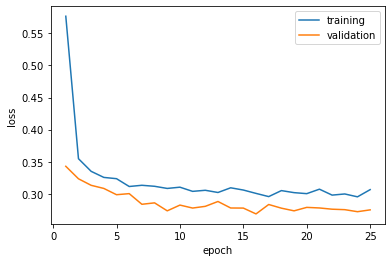

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### View Model Performance

Generating predictions from validation data..


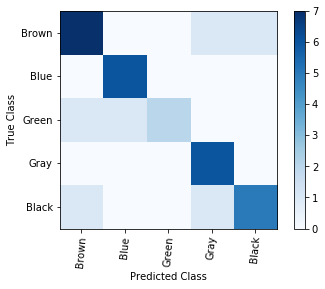

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score


print("Generating predictions from validation data..")

x_test = val_gen[0][0]
y_test = val_gen[0][1]

class_probabilities = model.predict(x_test)

predictions = np.argmax(class_probabilities, axis=1)

true_labels = np.argmax(y_test, axis=1)

classes = ["Brown", "Blue", "Green", "Gray" , "Black"]

cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes , rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [32]:
print(cm)

[[7 0 0 1 1]
 [0 6 0 0 0]
 [1 1 2 0 0]
 [0 0 0 6 0]
 [1 0 0 1 5]]


### Model CNN metric evaluation

In [33]:
print("Preparing testing dataset..")
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory=new_dir,
                                                  x_col=xcol,
                                                  y_col=ycol,
                                                  class_mode="categorical",
                                                  target_size = target_size,
                                                  batch_size=1,
                                                  shuffle=False)

filenames = test_gen.filenames
nb_samples = len(filenames)

prob = model.predict_generator(test_gen,steps = nb_samples)

Preparing testing dataset..
Found 2000 validated image filenames belonging to 5 classes.


In [34]:
pred = np.argmax(prob, axis=1)
true = np.array(test_gen.classes)

newcm = confusion_matrix(true, pred)

print(newcm)

[[374   9   0  22  15]
 [ 25 307   0  28  23]
 [ 31  12 310  25  11]
 [ 24   7   0 353  19]
 [ 25   7   0  32 341]]


In [35]:
acc = accuracy_score(true, pred)
rec = recall_score(true, pred, pos_label = 'positive', average ='macro') ## Weighted using macro
pre = precision_score(true,pred, pos_label = 'positive', average ='macro') ## Weighted using macro
f1 = f1_score(true,pred, pos_label = 'positive', average ='macro') ## Weighted using macro
print("Accuracy :" + str(acc))
print("Precision :" + str(pre))
print("Recall :" + str(rec))
print("F1 Score :" + str(f1))

Accuracy :0.8425
Precision :0.8559172547545136
Recall :0.8413727533879115
F1 Score :0.8443655728149826


C:\Users\Bear-\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1317: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


### Save Model

In [36]:
from keras.models import load_model

modelFileName = 'eyecolour-classifier.h5'
os.chdir("./B2")

model.save(modelFileName) # saves the trained model
print("Model saved.")
os.chdir("..")

Model saved.


In [37]:
print(train_gen.image_shape)

(32, 32, 3)


In [ ]:
del model  # deletes the existing model variable

In [ ]:


modelFileName = 'eyecolour-classifier.h5'
model = load_model

In [38]:
validation_accuracy = history.history['val_acc']
print(validation_accuracy)

[0.8407258064516129, 0.850609756097561, 0.8567073170731707, 0.8567073170731707, 0.866869918699187, 0.8592479674796748, 0.8658536585365854, 0.8683943089430894, 0.8729674796747967, 0.8658536585365854, 0.8663617886178862, 0.858739837398374, 0.8617886178861789, 0.8658536585365854, 0.8673780487804879, 0.8699186991869918, 0.8572154471544715, 0.8622967479674797, 0.8612804878048781, 0.8612804878048781, 0.8617886178861789, 0.858739837398374, 0.8617886178861789, 0.8658536585365854, 0.866869918699187]


In [41]:
print(validation_accuracy[-1])

0.866869918699187


In [109]:
pred = class_probabilities
real = y_test

acc = accuracy_score(real, pred)
rec = recall_score(real, pred)
pre = precision_score(real,pred)
f1 = f1_score(real,pred)
print("Accuracy :" + str(acc))
print("Precision :" + str(pre))
print("Recall :" + str(rec))
print("F1 Score :" + str(f1))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

# IGNORE CODE BELOW

In [53]:
# Starting to training the data and cross validate
# The cross validation is set to 10-fold 

y_pred1 = clf1.fit(train_data,train_label).predict(test_data) # Fitting the training data with RandomForestClassifier
acc1 = accuracy_score(y_pred1,test_label)
scores1 = cross_val_score(clf1, train_data,train_label, cv=10)

y_pred2 = clf2.fit(train_data,train_label).predict(test_data) # Fitting the training data with KNeighborsClassifier
acc2 = accuracy_score(y_pred2,test_label)
scores2 = cross_val_score(clf2, train_data,train_label, cv=10)

y_pred3 = clf3.fit(train_data,train_label).predict(test_data) # Fitting the training data with LinearSVC
acc3 = accuracy_score(y_pred3,test_label)
scores3 = cross_val_score(clf3, train_data,train_label, cv=10)

y_pred4 = clf4.fit(train_data,train_label).predict(test_data) # Fitting the training data with SVC
acc4 = accuracy_score(y_pred4,test_label)
scores4 = cross_val_score(clf4, train_data,train_label, cv=10)

y_pred5 = clf5.fit(train_data,train_label).predict(test_data) # Fitting the training data with LogisticRegression
acc5 = accuracy_score(y_pred5,test_label)
scores5 = cross_val_score(clf5, train_data,train_label, cv=10)

y_pred6 = clf6.fit(train_data,train_label).predict(test_data) # Fitting the training data with DecisionTreeClassifier
acc6 = accuracy_score(y_pred6,test_label)
scores6 = cross_val_score(clf6, train_data,train_label, cv=10)

# Getting the mean scores for the cross validation
scores1_mean = scores1.mean()
scores2_mean = scores2.mean()
scores3_mean = scores3.mean()
scores4_mean = scores4.mean()
scores5_mean = scores5.mean()
scores6_mean = scores6.mean()

print('By predicting using all features')
print("Accuracy",'%.2f'%acc1, "Score", '%.3f'%scores1_mean,"RandomForestClassifier")
print("Accuracy",'%.2f'%acc2, "Score", '%.3f'%scores2_mean,"KNeighborsClassifier")
print("Accuracy",'%.2f'%acc3, "Score", '%.3f'%scores3_mean,"LinearSVC")
print("Accuracy",'%.2f'%acc4, "Score", '%.3f'%scores4_mean,"SVC")
print("Accuracy",'%.2f'%acc5, "Score", '%.3f'%scores5_mean,"LogisticRegression")
print("Accuracy",'%.2f'%acc6, "Score", '%.3f'%scores6_mean,"DecisionTreeClassifier")

C:\Users\Bear-\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bear-\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bear-\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bear-\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bear-\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

By predicting using all features
Accuracy 0.72 Score 0.708 RandomForestClassifier
Accuracy 0.71 Score 0.687 KNeighborsClassifier
Accuracy 0.45 Score 0.497 LinearSVC
Accuracy 0.70 Score 0.691 SVC
Accuracy 0.69 Score 0.685 LogisticRegression
Accuracy 0.71 Score 0.703 DecisionTreeClassifier


C:\Users\Bear-\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(58, 58, 4)


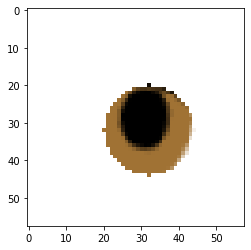

In [299]:
def transBg(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    roi, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, img.dtype)
    
    cv2.fillPoly(mask, roi, (255,)*img.shape[2], )
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def fourChans(img):
    height, width, channels = img.shape
    if channels<4 :
        new_img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
        return new_img
    return img

transmask = fourChans(masky)
transmask = transBg(transmask)
plt.imshow(transmask)
print(transmask.shape)

### Replace black background to white
This is done by inverting real image, intercept inverted real image with mask (using bitwise_and), then intercept image is then re-inverted.

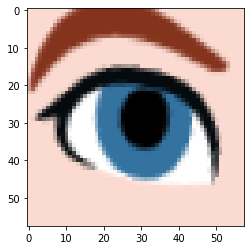

In [304]:
real = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
# final = cv2.bitwise_and(real, real, mask = transmask)

plt.imshow(real)

In [284]:
invreal = cv2.bitwise_not(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)) # Invert real image
# final = cv2.bitwise_and(invreal, invreal, mask = masky)
# final = cv2.bitwise_not(final)

print(len(masky))

58


In [ ]:
rgb = []
colour = ('b', 'g', 'r')
for i, col in enumerate(colour):
    histr = cv2.calcHist([final],[i], None, [256], [0,256])
    temp = np.delete(histr, 255)
    rgb.append(np.argmax(temp))

## Using CNN for training

### Convert Label data into dataframe

      Filename  EyeLabel EyeColour
0        0.png         1      Blue
1        1.png         2     Green
2        2.png         2     Green
3        3.png         2     Green
4        4.png         0     Brown
...        ...       ...       ...
9995  9995.png         3      Gray
9996  9996.png         0     Brown
9997  9997.png         1      Blue
9998  9998.png         0     Brown
9999  9999.png         2     Green

[10000 rows x 3 columns]


### Print Label Count (check for balanced or not)

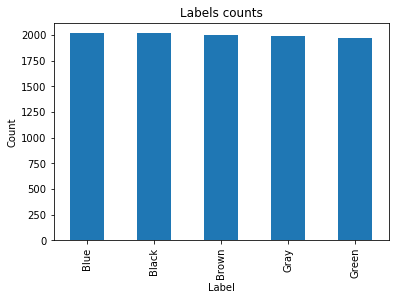

In [101]:
train_df, test_df = train_test_split(df, random_state=24)

In [ ]:
## Colour B-G-R code (0-255) -- High priority has better range
# Green 67-147-114 // priority in G
# lowGreen 47-107-94  # highGreen 87-187-134

# Black 0-0-0 // all priority in low
# lowBlack 0-0-0  ## highBlack 30-30-30

# Brown 53-72-124 // priority in R
# lowBrown 33-52-84  ## highBrown 73-92-164

# Gray/Torq 160-164-148 // priority in high
# lowGray 145-139-113  ## highGray 185-189-168

# Blue 160-114-52 // priority in B
# lowBlue 120-94-32  ## highBlue 200-134-72

boundaries = [([47,107,94],[87,187,134]),
              ([120,94,32],[200,134,72]),
              ([33,52,84],[73,92,164]),
              ([145,139,113],[185,189,168]),
              ([0,0,0],[30,30,30])]

In [238]:
def cropeye(images_dir, path):
    img_path = os.path.join(images_dir, path)
    img =  cv2.imread(img_path)
    cropped = img[230:230+58, 175:175+58]
    
    return cropped

def checkbound(b,g,r):
    cflag =0
    for lb in range(len(boundaries)):
        if b>= boundaries[lb][0][0] and b<= boundaries[lb][1][0]:
            cflag += 1
        if g>= boundaries[lb][0][1] and g<= boundaries[lb][1][1]:
            cflag += 1
        if r>= boundaries[lb][0][2] and r<= boundaries[lb][1][2]:
            cflag += 1

        if cflag ==3: ## if all three colours are within range
            return True
        else:
            cflag=0
    return False

def extract_feature_colour(images_dir, labels_dir):
    """ return:
        colour_features: an array contain argmax colour for BGR
        eye_labels: an array containing eye colour 1-5
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(labels_dir, 'r')
    lines = labels_file.readlines()
    eye_label = {line.split('\t')[0] : int(line.split('\t')[1]) for line in lines[1:]}
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        error_features = []
        for img_path in image_paths:
            file_name = img_path.split('.')[0].split('\\')[-1]
            crop = cropeye(images_dir, img_path.split('\\')[-1])
            gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            gray = cv2.medianBlur(gray,5)
            circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1,
                                       20,param1=50, param2=30,
                                       minRadius=3, maxRadius=40)
            
            # Could not find eye circle
            if cicles is None:
                error_features.append(filename)
                
            # Eye circle found
            else:
                circles = np.uint16(np.around(circles))
                x,y,r = circles[0,:][0]
                rows, cols = gray.shape
                for i in range(cols):
                    for j in range(rows):
                        if hypot(i-x, j-y) > r:
                            gray[j,i] = 0

                invreal = cv2.bitwise_not(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)) # Invert real image
                final = cv2.bitwise_and(invreal, invreal, mask = gray)
                final = cv2.bitwise_not(final)
                rgb = []
                colour = ('b', 'g', 'r')
                for i, col in enumerate(colour):
                    histr = cv2.calcHist([final],[i], None, [256], [0,256])
                    temp = np.delete(histr, 255)
                    rgb.append(np.argmax(temp))

                all_features.append(rgb)
                # check rgb within range and apply penalty if its not
                r,g,b = rgb
                if(checkbound(b,g,r) == False):
                    all_features.append(0)
                else:
                    all_features.append(1)

                all_labels.append(eye_label[file_name])
                
    colour_features = np.array(all_features)
    eye_labels = np.array(eye_label)
    
    return colour_features, eye_labels, error_features
    

In [ ]:
feat, lab, err = extract_feature_colour(images_dir, labels_dir)

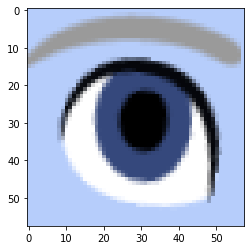

In [61]:

image_name = str(random.randrange(1,9999)) + '.png'
image_name = str(image_name)
temp = cropeye(images_dir, image_name)
image_plot = plt.imshow(temp)

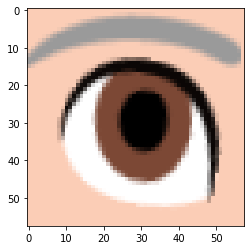

In [62]:
koko = temp.copy()
realtemp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
# img_gray = cv2.cvtColor(purple_img, cv2.COLOR_BGR2GRAY)
image_plot = plt.imshow(realtemp)


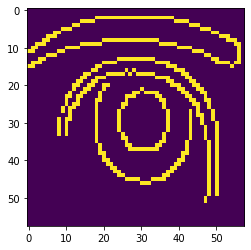

In [63]:
tempgray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
tempgray = cv2.bilateralFilter(tempgray, 11, 17, 17)
edged = cv2.Canny(tempgray, 30, 200)

image_plot = plt.imshow(edged)

In [64]:
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

# find contours in the edged image, keep only the largest
# ones, and initialize our screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [65]:
print(len(cnts))

6


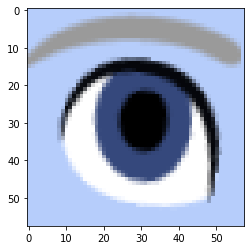

In [75]:

image_plot = plt.imshow(gege)

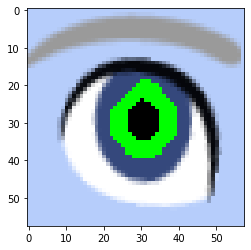

In [76]:
gege = temp.copy()
peri = cv2.arcLength(cnts[1], True)
approx = cv2.approxPolyDP(cnts[1], 0.015* peri, True)
cv2.drawContours(gege, [approx], -1, (0,255,0), 3)

image_plot = plt.imshow(gege)

In [ ]:
# loop over our contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.015 * peri, True)
    
    cv2.drawContours(temp, [approx], -1, (0, 255, 0), 3)
    



# image_plot = plt.imshow(image)

24


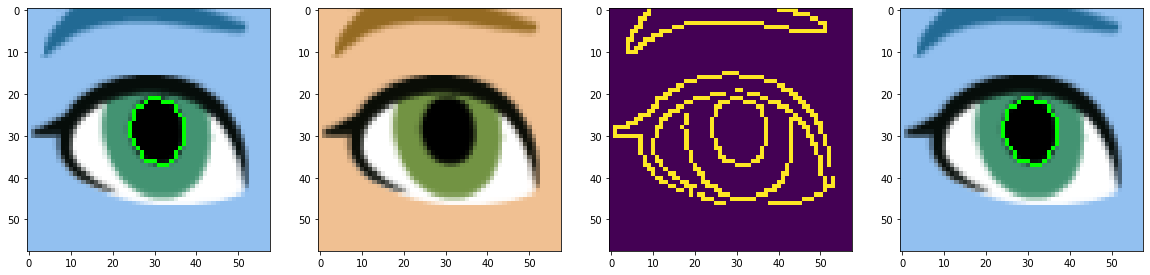

In [103]:
printimage =[]

image_name = str(random.randrange(1,9999)) + '.png'
image_name = str(image_name)
temp = cropeye(images_dir, image_name)
printimage.append(temp)
real = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
printimage.append(real)
tempgray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
tempgray = cv2.bilateralFilter(tempgray, 11, 17, 17)
edged = cv2.Canny(tempgray, 30, 200)
printimage.append(edged)

cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]


peri = cv2.arcLength(cnts[1], True)
approx = cv2.approxPolyDP(cnts[1], 0.015* peri, True)
final = cv2.drawContours(temp, [approx], -1, (0,255,0), 1)
print(len(cnts[1]))
printimage.append(final)

fig = plt.figure(figsize = (20,20))
num = len(printimage)
count = 1
for exam in printimage:
    a=fig.add_subplot(1, num, count)
    image_plot = plt.imshow(exam)
    count = count+1
    
plt.show()

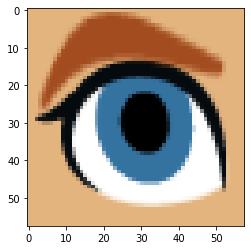

In [127]:
test_name = str(str(random.randrange(1,9999)) + '.png')
testing = cropeye(images_dir, test_name)
image_plot = plt.imshow(cv2.cvtColor(testing, cv2.COLOR_BGR2RGB))

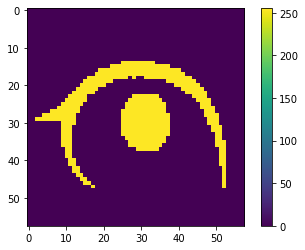

In [204]:
ret,mask = cv2.threshold(testgray, 0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) 
_,mask3 = cv2.threshold(testgray, 20,255,cv2.THRESH_BINARY_INV)
# mask = cv2.inRange(testing, lower_white, upper_white)  # could also use threshold
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))  # "erase" the small white points in the resulting mask
# mask = cv2.bitwise_not(mask)  # invert mask
#apply AND operation on image and mask generated by thrresholding
testgray = cv2.bilateralFilter(testgray, 11, 17, 17)
edged = cv2.Canny(testgray, 30, 200)
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# testmask = cv2.bitwise_and(mask,mask,mask = mask3)
# mask2 = cv2.bitwise_and(mask,mask,mask=edged)
final = cv2.bitwise_and(testing,testing,mask = mask)
rgbfinal = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
#plot the result
plt.imshow(testmask)
plt.colorbar()

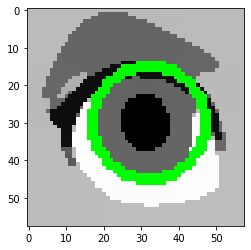

In [218]:
img = testgray.copy()
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=6,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
#     cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.imshow(cimg)
plt.show()

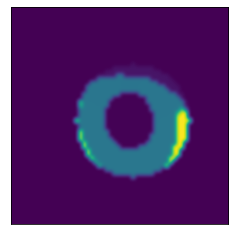

In [227]:
from math import hypot
img = testgray.copy()
img = cv2.medianBlur(img,5)
# cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=6,maxRadius=0)

circles = np.uint16(np.around(circles))

x, y, r = circles[0,:][0]
rows, cols = img.shape

for i in range(cols):
    for j in range(rows):
        if hypot(i-x, j-y) > r:
            img[j,i] = 0

plt.imshow(img, interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

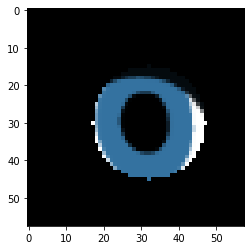

In [231]:
realtest = cv2.cvtColor(testing,cv2.COLOR_BGR2RGB)
final = cv2.bitwise_and(realtest,realtest,mask=img)
plt.imshow(final)

0

0

0

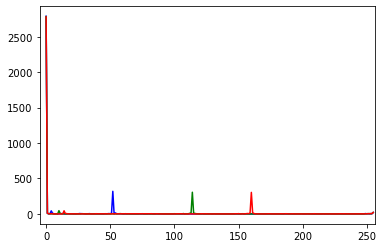

In [230]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([final],[i],None,[256],[0,256])
    ayy = np.delete(histr, 255)
    display(np.argmax(ayy))
#     print(len(histr))
    plt.plot(histr,color = col)
    plt.xlim([-5,256])
plt.show()

In [15]:
## Colour B-G-R code (0-255) -- High priority has better range
# Green 67-147-114 // priority in G
# lowGreen 47-107-94  # highGreen 87-187-134

# Black 0-0-0 // all priority in low
# lowBlack 0-0-0  ## highBlack 30-30-30

# Brown 53-72-124 // priority in R
# lowBrown 33-52-84  ## highBrown 73-92-164

# Gray/Torq 160-164-148 // priority in high
# lowGray 145-139-113  ## highGray 185-189-168

# Blue 160-114-52 // priority in B
# lowBlue 120-94-32  ## highBlue 200-134-72

boundaries = [([47,107,94],[87,187,134]),
              ([120,94,32],[200,134,72]),
              ([33,52,84],[73,92,164]),
              ([145,139,113],[185,189,168]),
              ([0,0,0],[30,30,30])]

def checkbound(b,g,r):
    cflag =0
    for lb in range(len(boundaries)):
        if b>= boundaries[lb][0][0] and b<= boundaries[lb][1][0]:
            cflag += 1
        if g>= boundaries[lb][0][1] and g<= boundaries[lb][1][1]:
            cflag += 1
        if r>= boundaries[lb][0][2] and r<= boundaries[lb][1][2]:
            cflag += 1

        if cflag ==3: ## if all three colours are within range
            return True
        else:
            cflag=0
    return False

<class 'numpy.ndarray'>


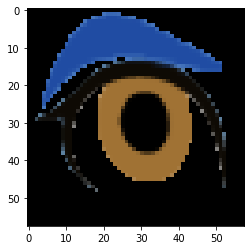

In [153]:
plt.imshow(final)
print(type(final))

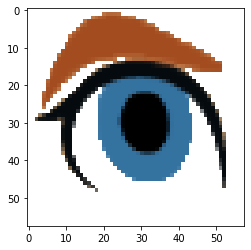

In [179]:
# opencv loads the image in BGR, convert it to RGB
img = cv2.cvtColor(testing,
                   cv2.COLOR_BGR2RGB)
imggray = cv2.cvtColor(testing, cv2.COLOR_BGR2GRAY)
# lower_white = np.array([220, 220, 220], dtype=np.uint8)
# upper_white = np.array([255, 255, 255], dtype=np.uint8)
# mask = cv2.inRange(img, lower_white, upper_white)  # could also use threshold
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))  # "erase" the small white points in the resulting mask
# mask = cv2.bitwise_not(mask)  # invert mask
ret,mask = cv2.threshold(imggray, 0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) 

# load background (could be an image too)
bk = np.full(img.shape, 255, dtype=np.uint8)  # white bk

# get masked foreground
fg_masked = cv2.bitwise_and(img, img, mask=mask)

# get masked background, mask must be inverted 
mask = cv2.bitwise_not(mask)
bk_masked = cv2.bitwise_and(bk, bk, mask=mask)

# combine masked foreground and masked background 
final = cv2.bitwise_or(fg_masked, bk_masked)
mask = cv2.bitwise_not(mask)  # revert mask to original

image_plot = plt.imshow(final)

52

114

160

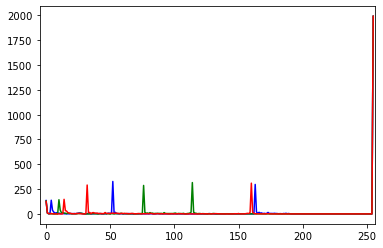

In [164]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([final],[i],None,[256],[0,256])
    ayy = np.delete(histr, 255)
    display(np.argmax(ayy))
#     print(len(histr))
    plt.plot(histr,color = col)
    plt.xlim([-5,256])
plt.show()

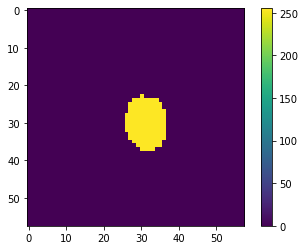

In [136]:
testgray = cv2.cvtColor(testing, cv2.COLOR_BGR2GRAY)
retval, thresholded = cv2.threshold(testgray, 0, 255, cv2.THRESH_BINARY_INV)

image_plot = plt.imshow(thresholded)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


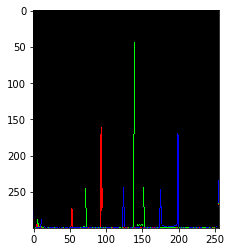

In [17]:
bins = np.arange(256).reshape(256,1)

def hist_curve(im):
    h = np.zeros((300,256,3))
    if len(im.shape) == 2:
        color = [(255,255,255)]
    elif im.shape[2] == 3:
        color = [ (255,0,0),(0,255,0),(0,0,255) ]
    for ch, col in enumerate(color):
        hist_item = cv2.calcHist([im],[ch],None,[256],[0,256])
        cv2.normalize(hist_item,hist_item,0,255,cv2.NORM_MINMAX)
        hist=np.int32(np.around(hist_item))
        pts = np.int32(np.column_stack((bins,hist)))
        cv2.polylines(h,[pts],False,col)
    y=np.flipud(h)
    return y

image_plot = plt.imshow(hist_curve(temp))

In [14]:
chans = cv2.split(temp)
colors = ('b', 'g', 'r')
features = []
feature_data = ''

for (chan, color) in zip(chans, colors):
    hist = cv2.calcHist([chan], [0], None, [256], [0,256])
    


array([[1.230e+02],
       [7.000e+00],
       [3.000e+00],
       [1.000e+00],
       [1.000e+00],
       [6.600e+01],
       [1.200e+01],
       [1.000e+01],
       [1.200e+01],
       [1.000e+01],
       [2.000e+00],
       [2.000e+00],
       [6.000e+00],
       [6.000e+00],
       [4.000e+00],
       [3.000e+00],
       [4.000e+00],
       [2.000e+00],
       [6.000e+00],
       [1.000e+00],
       [5.000e+00],
       [4.000e+00],
       [3.000e+00],
       [3.000e+00],
       [0.000e+00],
       [4.000e+00],
       [5.000e+00],
       [3.000e+00],
       [2.000e+00],
       [6.000e+00],
       [3.000e+00],
       [4.000e+00],
       [5.000e+00],
       [6.000e+00],
       [3.000e+00],
       [3.000e+00],
       [4.000e+00],
       [3.000e+00],
       [6.000e+00],
       [5.000e+00],
       [4.000e+00],
       [5.000e+00],
       [6.000e+00],
       [4.000e+00],
       [6.000e+00],
       [3.000e+00],
       [8.000e+00],
       [5.000e+00],
       [3.000e+00],
       [3.000e+00],


array([[1.23e+02],
       [5.00e+00],
       [4.00e+00],
       [1.00e+00],
       [1.00e+00],
       [0.00e+00],
       [6.10e+01],
       [1.10e+01],
       [6.00e+00],
       [5.00e+00],
       [9.00e+00],
       [1.00e+01],
       [8.00e+00],
       [2.00e+00],
       [0.00e+00],
       [4.00e+00],
       [6.00e+00],
       [1.00e+00],
       [5.00e+00],
       [3.00e+00],
       [3.00e+00],
       [2.00e+00],
       [3.00e+00],
       [4.00e+00],
       [5.00e+00],
       [0.00e+00],
       [2.00e+00],
       [3.00e+00],
       [4.00e+00],
       [2.00e+00],
       [2.00e+00],
       [3.00e+00],
       [2.00e+00],
       [1.00e+00],
       [1.00e+00],
       [4.00e+00],
       [4.00e+00],
       [4.00e+00],
       [4.00e+00],
       [3.00e+00],
       [1.00e+00],
       [2.00e+00],
       [2.00e+00],
       [6.00e+00],
       [4.00e+00],
       [3.00e+00],
       [3.00e+00],
       [3.00e+00],
       [4.00e+00],
       [1.00e+00],
       [2.00e+00],
       [2.00e+00],
       [4.00

array([[1.210e+02],
       [2.000e+00],
       [4.000e+00],
       [3.000e+00],
       [2.000e+00],
       [1.000e+00],
       [0.000e+00],
       [1.000e+00],
       [0.000e+00],
       [0.000e+00],
       [1.000e+00],
       [6.100e+01],
       [9.000e+00],
       [4.000e+00],
       [5.000e+00],
       [1.100e+01],
       [6.000e+00],
       [2.000e+00],
       [6.000e+00],
       [1.000e+00],
       [4.000e+00],
       [5.000e+00],
       [1.000e+00],
       [1.000e+00],
       [2.000e+00],
       [1.000e+00],
       [2.000e+00],
       [4.000e+00],
       [2.000e+00],
       [4.000e+00],
       [1.000e+00],
       [2.000e+00],
       [1.000e+00],
       [2.000e+00],
       [2.000e+00],
       [3.000e+00],
       [2.000e+00],
       [4.000e+00],
       [1.000e+00],
       [2.000e+00],
       [1.000e+00],
       [5.000e+00],
       [2.000e+00],
       [4.000e+00],
       [0.000e+00],
       [1.000e+00],
       [2.000e+00],
       [1.000e+00],
       [3.000e+00],
       [4.000e+00],


In [23]:
chans = cv2.split(temp)
colors = ('b', 'g', 'r')
features = []
feature_data = ''
counter = 0
for (chan, color) in zip(chans, colors):
    counter = counter + 1

    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)

    # find the peak pixel values for R, G, and B
    elem = np.argmax(hist)
    print(elem)

    if counter == 1:
        blue = str(elem)
    elif counter == 2:
        green = str(elem)
    elif counter == 3:
        red = str(elem)
        feature_data = red + ',' + green + ',' + blue

182
205
251


In [22]:
print(feature_data)

251,205,182


### Trying to detect colour of the eye

In [87]:
## Colour B-G-R code (0-255) -- High priority has better range
# Green 67-147-114 // priority in G
# lowGreen 47-107-94  # highGreen 87-187-134

# Black 0-0-0 // all priority in low
# lowBlack 0-0-0  ## highBlack 30-30-30

# Brown 53-72-124 // priority in R
# lowBrown 33-52-84  ## highBrown 73-92-164

# Gray/Torq 160-164-148 // priority in high
# lowGray 145-139-113  ## highGray 185-189-168

# Blue 160-114-52 // priority in B
# lowBlue 120-94-32  ## highBlue 200-134-72

boundaries = [([47,107,94],[87,187,134]),
              ([120,94,32],[200,134,72]),
              ([33,52,84],[73,92,164]),
              ([145,139,113],[185,189,168])]
#               ([0,0,0],[30,30,30])]

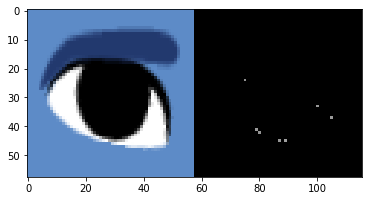

In [88]:

# loop over the boundaries
for (lower, upper) in boundaries:
    # create NumPy arrays from the boundaries
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(temp, lower, upper)
    output = cv2.bitwise_and(temp, temp, mask = mask)

    # show the images
    imageoutput = np.hstack([temp, output])
    image_plot = plt.imshow(imageoutput)

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 1440x1440 with 0 Axes>

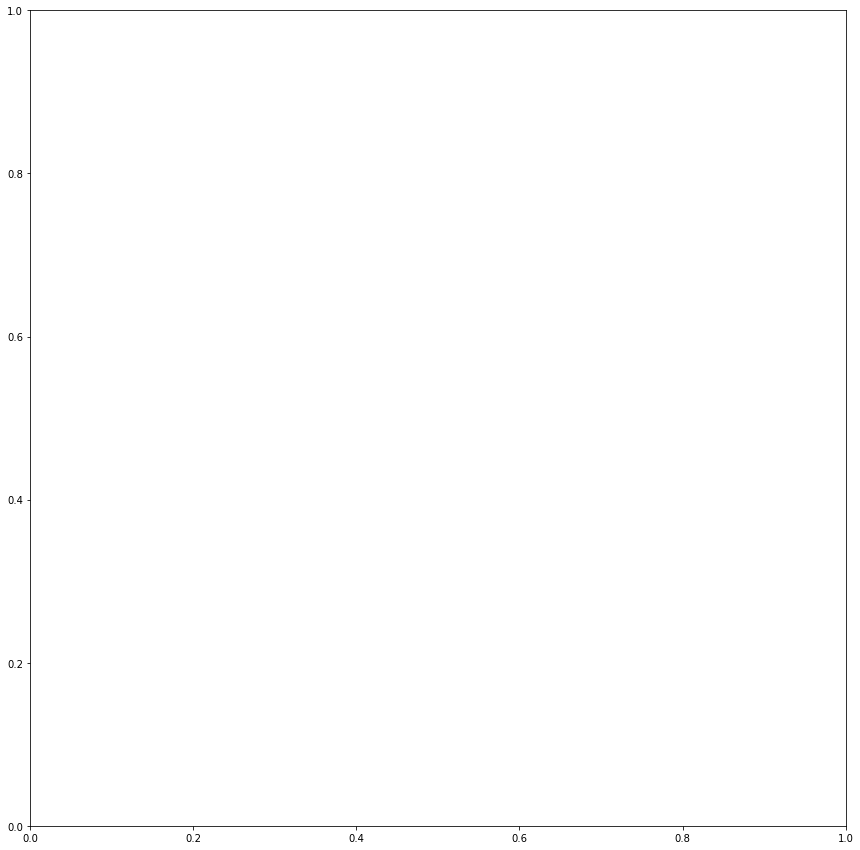

In [7]:
# example_image = ['1010.png','1159.png','4066.png','2368.png','3034.png']
example_image = ['1010.png']
img_list = []
fig = plt.figure(figsize = (20,20))

for example_img in example_image:
    img_list.append(geteye(images_dir, example_img))
    
fig = plt.figure(figsize=(15,15))
num_images = len(img_list)

for image_idx in range(num_images):
    # Keep an incrementing count of each image
    a=fig.add_subplot(1, num_images, image_idx+1)
    # Add the image to the plot
    image_plot = plt.imshow(img_list[image_idx])
    # Add a caption with the folder name
    a.set_title("Image " + example_image[image_idx])

plt.show()

In [8]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [9]:
def extract_features_labels(images_dir, labels_dir): ## eye colour, face shape
    """ return:
        landmark_features:  an array containing 68 landmark points for each image in celeba folder
        fshape_labels:      an array containing the face shape label (0,1,2,3,4) for each image
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)] ##filename in matrix
    target_size = None
    labels_file = open(labels_dir, 'r')
    lines = labels_file.readlines()
    fshape_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]} ##fetch filename + faceshape
#     ecolor_labels = {line.split('\t')[0] : int(line.split('\t')[1]) for line in lines[1:]} 
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        error_features = []
        for img_path in image_paths:
            file_name= img_path.split('.')[0].split('\\')[-1] ##getting name of file; remove png/jpg + dir

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(fshape_labels[file_name])
            if features is None:
                error_features.append(file_name)
                

    landmark_features = np.array(all_features)
    fshape_labels = np.array(all_labels)
    return landmark_features, fshape_labels, error_features

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image
    
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

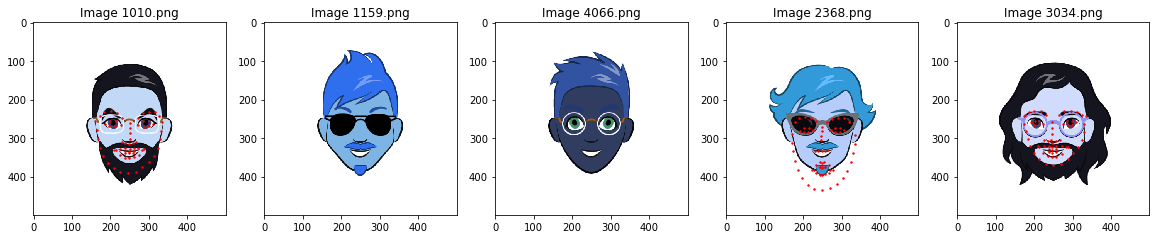

In [10]:
example_image = ['1010.png','1159.png','4066.png','2368.png','3034.png']
img_list = []
img_id = 1
fig = plt.figure(figsize = (20,20))

for example_img in example_image:
    path = os.path.join(images_dir, example_img)
    ex_img = image.img_to_array(image.load_img(path, target_size = None, interpolation='bicubic'))
    ex_feat,_ = run_dlib_shape(ex_img)
    cv_img = cv2.imread(path)
    
    a=fig.add_subplot(1, len(example_image), img_id)
    image_plot = plt.imshow(cv_img)
    a.set_title("Image " + example_img)
    img_id = img_id+1
    
    if ex_feat is not None:
        x,y = np.split(ex_feat, 2, axis=1)
        plt.scatter(x,y,c='red', s=2)

plt.show()

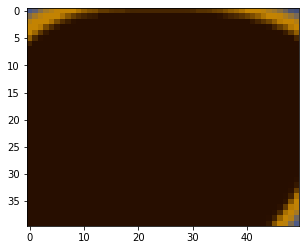

In [22]:
def eye_crop_img(file_dir): ## Crop to get only right eye
    orig = cv2.imread(file_dir)
    crop = orig[240:280 , 180:230]
    
#     crop = orig[180:220 , 240:290]
    return crop

temp = eye_crop_img(os.path.join(images_dir, '102.png'))
image_plot = plt.imshow(temp)